In [8]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

# Setup the Data

In [9]:
import pathlib

data_dir = pathlib.Path('data')
print(f"Corrected data directory: {data_dir}")

if data_dir.exists():
    print("Directory exists")
else:
    print("Directory does not exist")

all_files = list(data_dir.glob('**/*'))
print(f"Total files found: {len(all_files)}")

image_files = list(data_dir.glob('**/*.png'))
image_count = len(image_files)
print(f"Total image files found: {image_count}")

Corrected data directory: data
Directory exists
Total files found: 836
Total image files found: 556


In [10]:
# horses = list(data_dir.glob('horse/*'))
# PIL.Image.open(str(horses[0]))

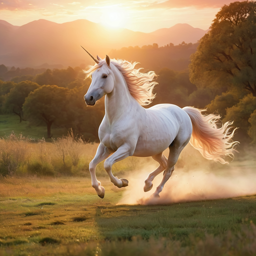

In [11]:
unicorns = list(data_dir.glob('unicorn/*'))
PIL.Image.open(str(unicorns[0]))

# Define parameters

In [12]:
batch_size = 16
img_height = 256
img_width = 256

# Split training and validaiton set

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 556 files belonging to 2 classes.


Using 445 files for training.


I0000 00:00:1739101471.551042  198595 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 556 files belonging to 2 classes.
Using 111 files for validation.
['horse', 'unicorn']


# Check input data shape

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


# Cache and prefetch the data for more performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Standardize the data

In [16]:
normalization_layer = layers.Rescaling(1./255)

# Make the Model

In [17]:
num_classes = len(class_names)


model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/home/timo/Machine-Learning-WiSe2425/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1739101473.681458  199294 service.cc:148] XLA service 0x7fa05c005990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739101473.681484  199294 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-02-09 12:44:33.695441: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739101473.765981  199294 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-09 12:44:35.251509: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng24{k2=0,k13=2,k14=3,k18=0,k23=0} for conv (f32[16,16,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,256,256]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"a

 1/28 ━━━━━━━━━━━━━━━━━━━━ 4:09 9s/step - accuracy: 0.4375 - loss: 0.7057

I0000 00:00:1739101482.007187  199294 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/28 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.5155 - loss: 1.7327

2025-02-09 12:44:50.108438: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng33{k2=2,k6=2,k13=1,k14=0,k22=0} for conv (f32[13,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,16,128,128]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-09 12:44:50.313534: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.205185655s
Trying algorithm eng33{k2=2,k6=2,k13=1,k14=0,k22=0} for conv (f32[13,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,16,128,128]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call

28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 465ms/step - accuracy: 0.5381 - loss: 1.5952 - val_accuracy: 0.8288 - val_loss: 0.4167
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8775 - loss: 0.2880 - val_accuracy: 0.9550 - val_loss: 0.0930
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9741 - loss: 0.0761 - val_accuracy: 0.9369 - val_loss: 0.1096
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9710 - loss: 0.0891 - val_accuracy: 0.9459 - val_loss: 0.1791
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9739 - loss: 0.0660 - val_accuracy: 0.9459 - val_loss: 0.1429
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9640 - val_loss: 0.0616
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9640 - val_loss: 0.0728
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 6.6588e-04 - val_accuracy: 0.9550 - val_lo

# Visualize training results

In [20]:
def show_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    
    plt.show()


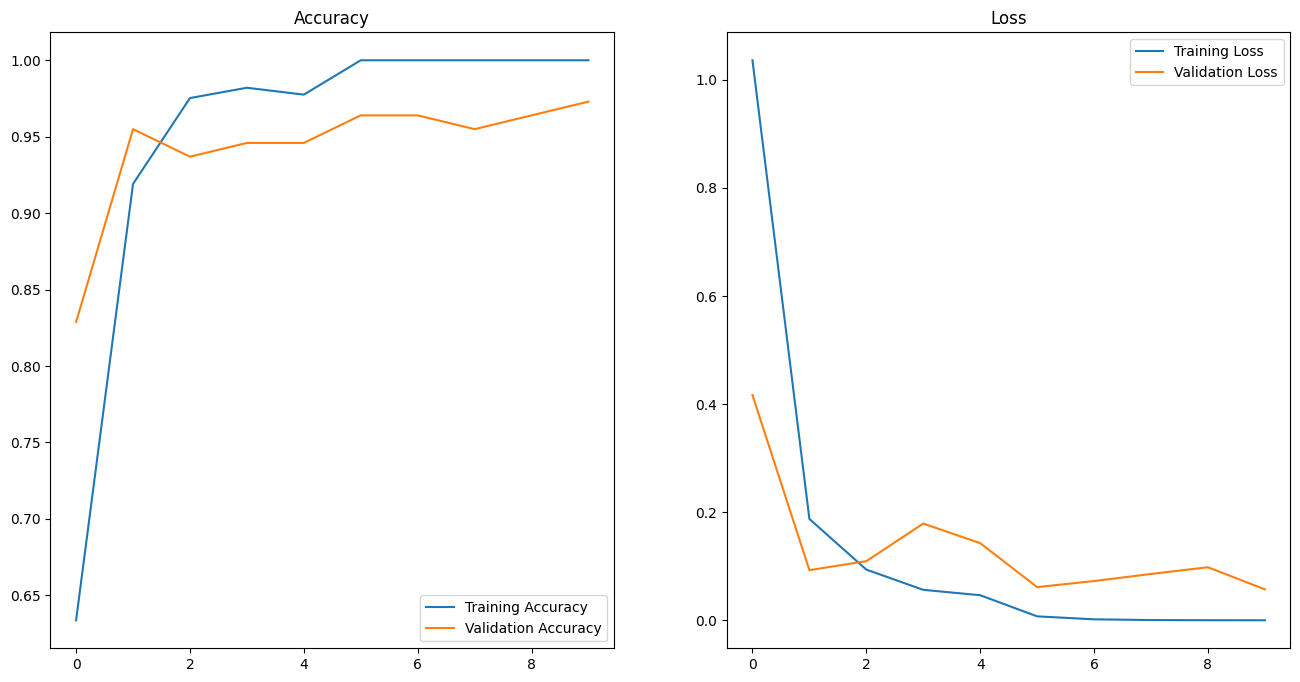

In [21]:
show_results(history)

# Avoid Overfitting

Adding Data augmentaiton, Dropout and early stopping

2025-02-09 12:45:00.224359: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


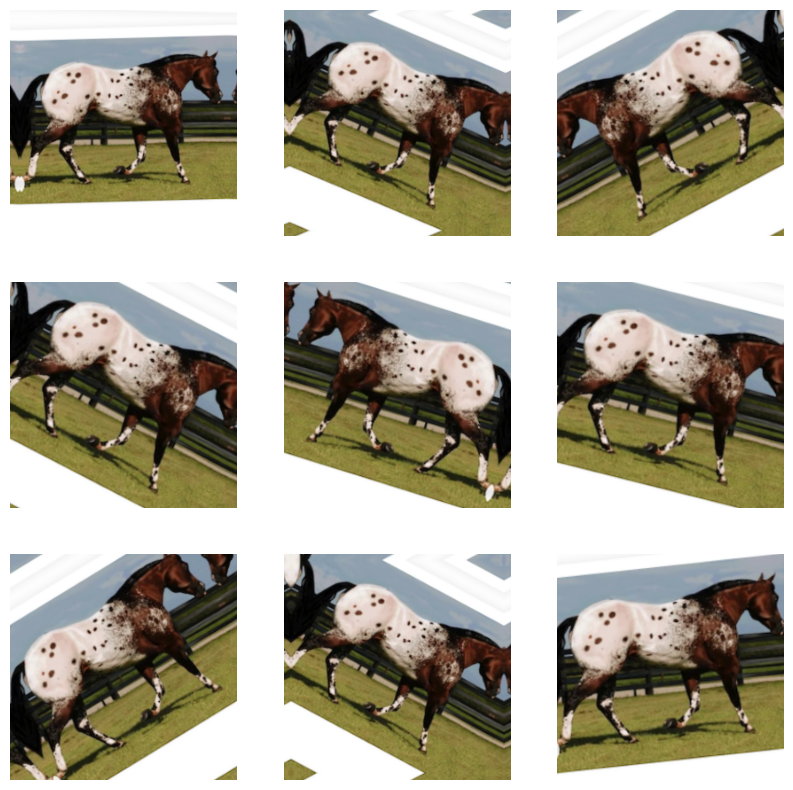

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Epoch 1/25


E0000 00:00:1739101501.183042  198595 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6384 - loss: 0.9072 - val_accuracy: 0.9550 - val_loss: 0.1283
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9609 - loss: 0.1495 - val_accuracy: 0.9459 - val_loss: 0.1422
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9449 - loss: 0.1486 - val_accuracy: 0.9550 - val_loss: 0.1220
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9586 - loss: 0.1336 - val_accuracy: 0.9730 - val_loss: 0.0570
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9414 - loss: 0.1011 - val_accuracy: 0.9820 - val_loss: 0.0466
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9824 - loss: 0.0393 - val_accuracy: 0.9550 - val_loss: 0.0937
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9809 - loss: 0.0521 - val_accuracy: 0.9730 - val_loss: 0.0437
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9891 - loss: 0.0383 - val_accuracy: 0.9820 - val_loss: 0.

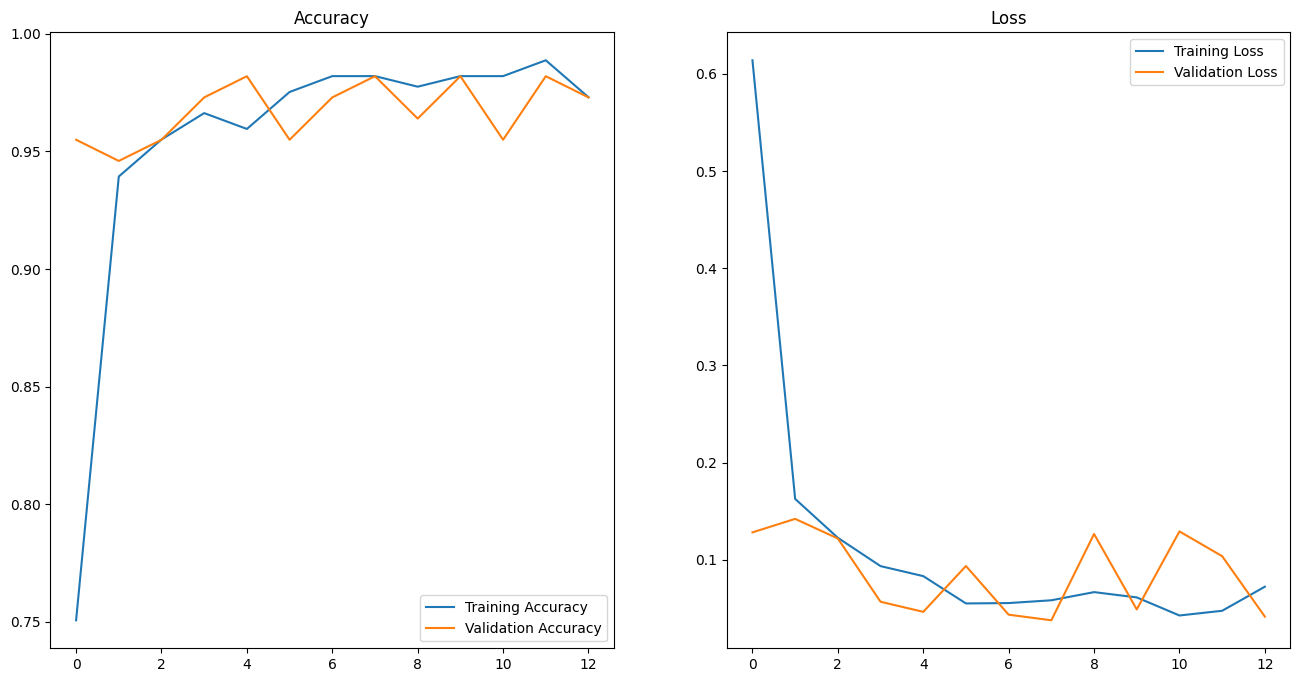

In [23]:
# Bestes Modell

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)


# Refining the Model

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6372 - loss: 0.7832 - val_accuracy: 0.9550 - val_loss: 0.1627
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9330 - loss: 0.1657 - val_accuracy: 0.9640 - val_loss: 0.0948
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9666 - loss: 0.1064 - val_accuracy: 0.9640 - val_loss: 0.0835
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9702 - loss: 0.0780 - val_accuracy: 0.9910 - val_loss: 0.0505
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9583 - loss: 0.1102 - val_accuracy: 0.9730 - val_loss: 0.0559
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9737 - loss: 0.1077 - val_accuracy: 0.9550 - val_loss: 0.1647
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9825 - loss: 0.0527 - val_accuracy: 0.9730 - val_loss: 0.0714
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9749 - loss: 0.0654 - val_accuracy: 0.9730 - v

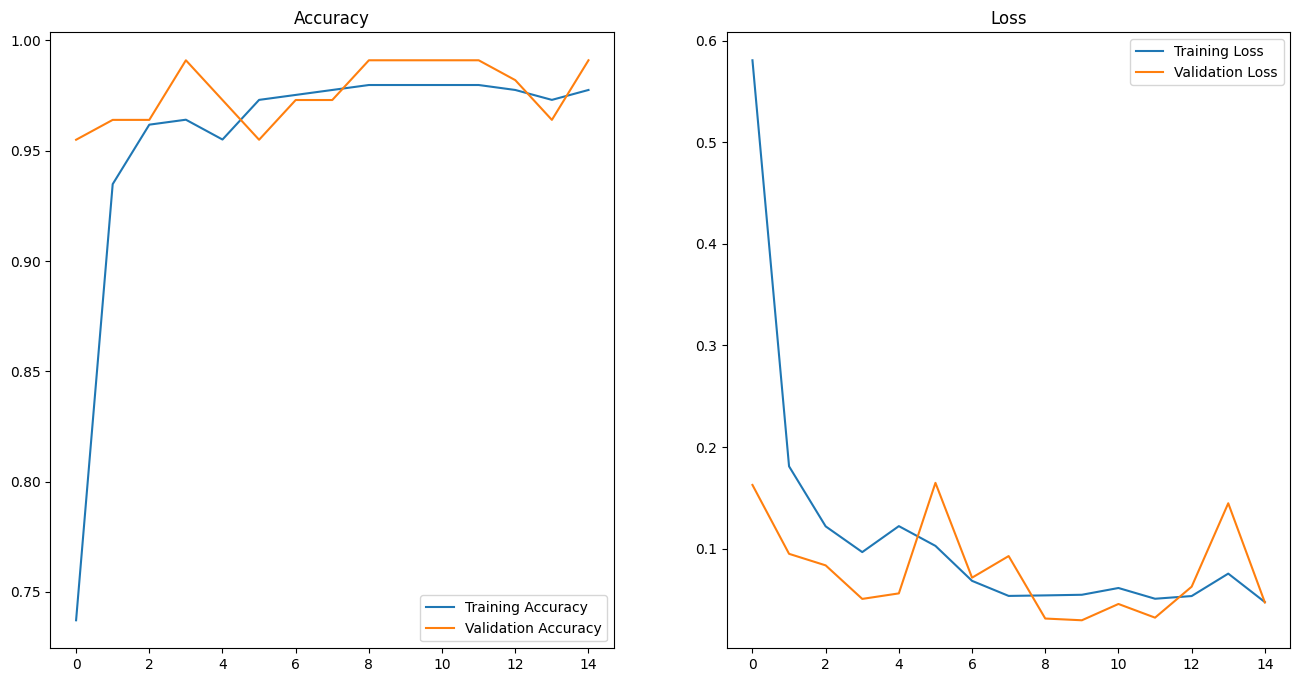

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7233 - loss: 0.5478 - val_accuracy: 0.8829 - val_loss: 0.2489
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9037 - loss: 0.2099 - val_accuracy: 0.9730 - val_loss: 0.1165
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9415 - loss: 0.1352 - val_accuracy: 0.9279 - val_loss: 0.1684
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9514 - loss: 0.1110 - val_accuracy: 0.9550 - val_loss: 0.1576
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9515 - loss: 0.1379 - val_accuracy: 0.9640 - val_loss: 0.0947
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9629 - loss: 0.0831 - val_accuracy: 0.9640 - val_loss: 0.0901
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9680 - loss: 0.0932 - val_accuracy: 0.9730 - val_loss: 0.0725
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9632 - loss: 0.0782 - val_accuracy: 0.9459 - v

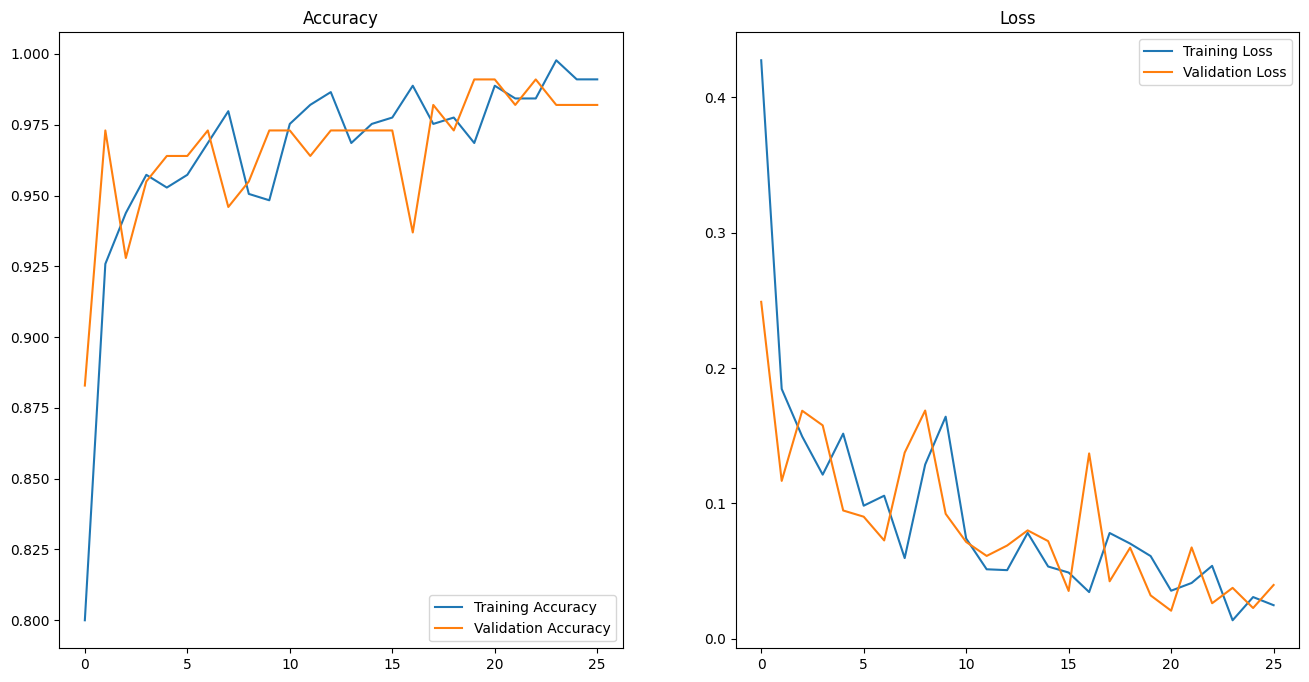

In [25]:


model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

Make the Convolution and Pooling smaller

Epoch 1/50


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6776 - loss: 0.6483 - val_accuracy: 0.9099 - val_loss: 0.2089
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9317 - loss: 0.1724 - val_accuracy: 0.9189 - val_loss: 0.1415
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9782 - loss: 0.0731 - val_accuracy: 0.9459 - val_loss: 0.1165
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9339 - loss: 0.1503 - val_accuracy: 0.9369 - val_loss: 0.1132
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9544 - loss: 0.1211 - val_accuracy: 0.9730 - val_loss: 0.0551
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9711 - loss: 0.1013 - val_accuracy: 0.9730 - val_loss: 0.0554
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9586 - loss: 0.0921 - val_accuracy: 0.9730 - val_loss: 0.1208
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9561 - loss: 0.1028 - val_accuracy: 0.9820 - val_loss: 0.

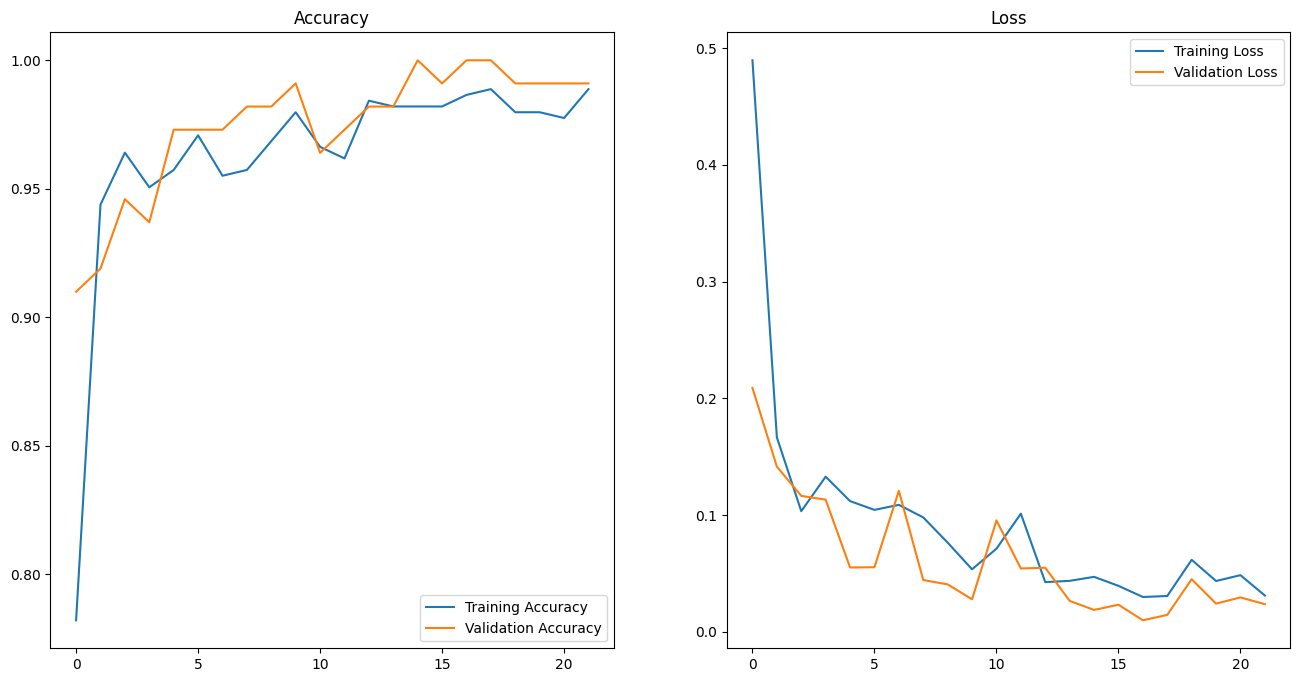

In [26]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

change batch size

Found 556 files belonging to 2 classes.
Using 445 files for training.


Found 556 files belonging to 2 classes.
Using 111 files for validation.
['horse', 'unicorn']
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5953 - loss: 0.6487 - val_accuracy: 0.8468 - val_loss: 0.2948
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8906 - loss: 0.2644 - val_accuracy: 0.8649 - val_loss: 0.2641
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9271 - loss: 0.1651 - val_accuracy: 0.9369 - val_loss: 0.1793
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9621 - loss: 0.1334 - val_accuracy: 0.9550 - val_loss: 0.1463
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9545 - loss: 0.1254 - val_accuracy: 0.9099 - val_loss: 0.2656
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9476 - loss: 0.1584 - val_accuracy: 0.9640 - val_loss: 0.1143
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9145 - loss: 0.1970 - val_accuracy: 0.9640 - val_loss: 0.1345
Epoc

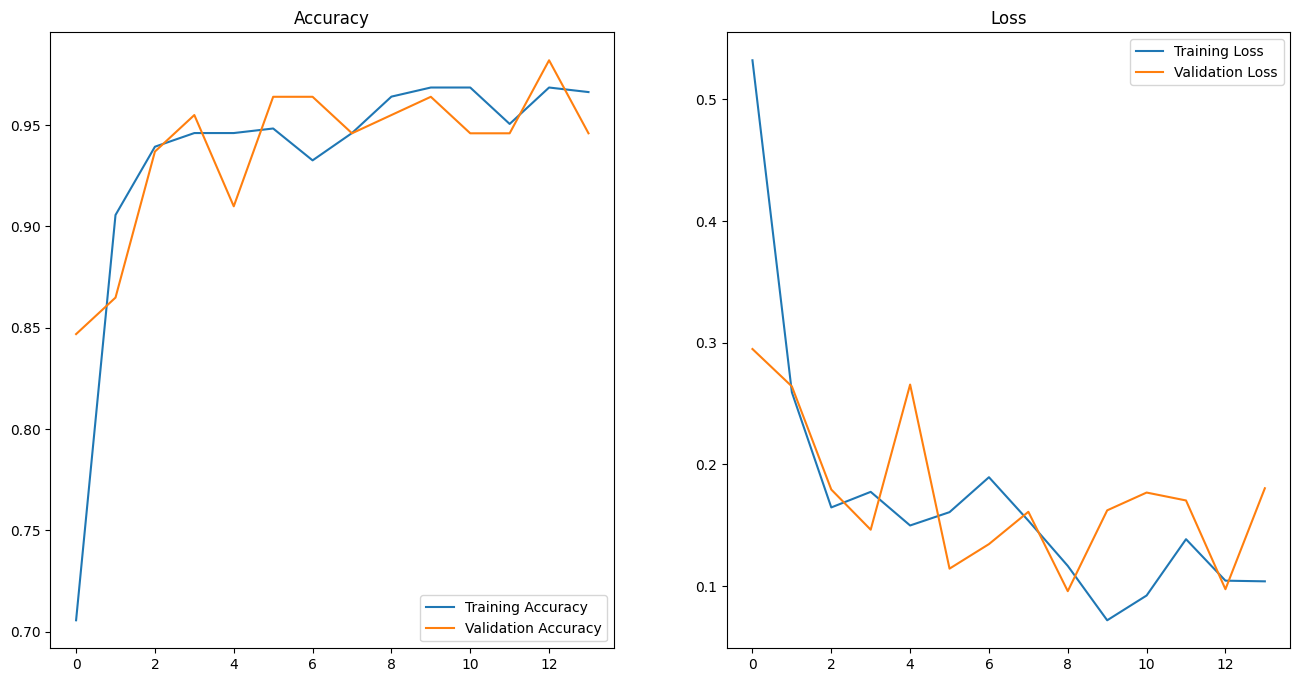

In [27]:
batch_size = 4
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

Epoch 1/50


E0000 00:00:1739101566.418775  198595 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_5_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4947 - loss: 0.7645 - val_accuracy: 0.4865 - val_loss: 0.6933
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4677 - loss: 0.6953 - val_accuracy: 0.4865 - val_loss: 0.6935
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5024 - loss: 0.6937 - val_accuracy: 0.5135 - val_loss: 0.6924
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6355 - loss: 0.6498 - val_accuracy: 0.7748 - val_loss: 0.4842
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8284 - loss: 0.4545 - val_accuracy: 0.8829 - val_loss: 0.3080
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8703 - loss: 0.3301 - val_accuracy: 0.7477 - val_loss: 0.4947
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8454 - loss: 0.3523 - val_accuracy: 0.8829 - val_loss: 0.3176
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9004 - loss: 0.2450 - val_accuracy: 0.882

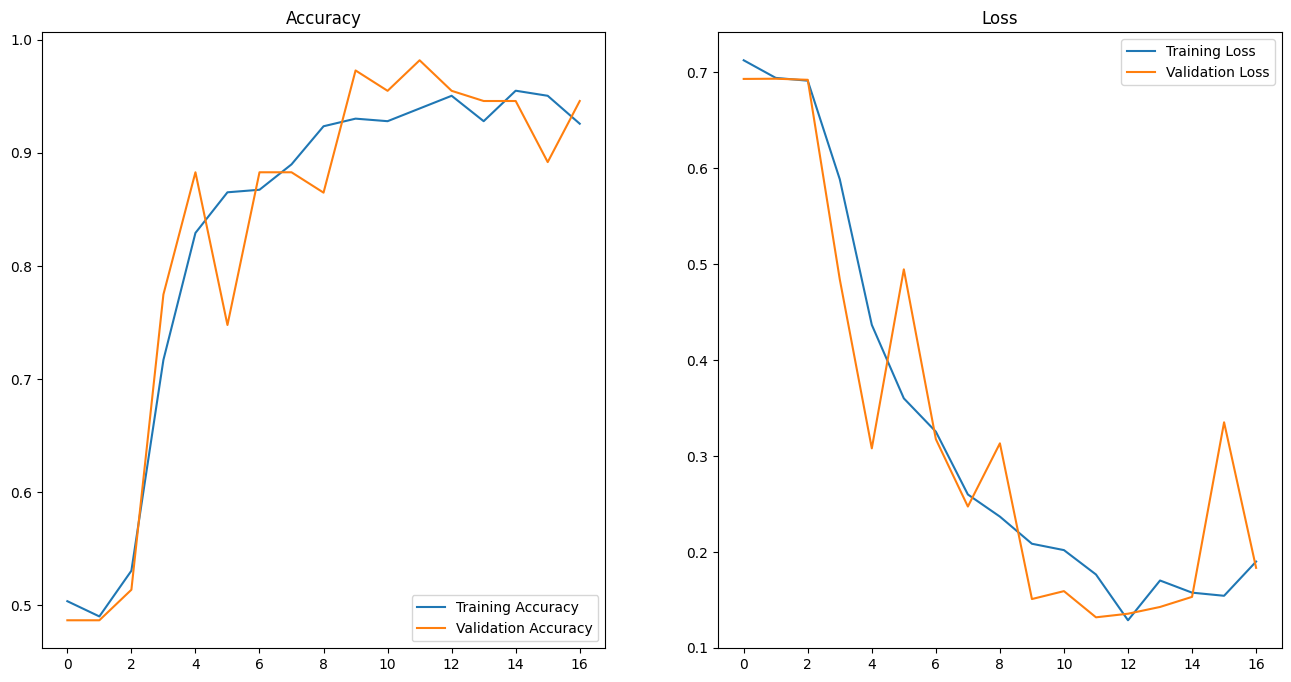

In [28]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5079 - loss: 0.7168 - val_accuracy: 0.4865 - val_loss: 0.6924
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6993 - loss: 0.5758 - val_accuracy: 0.9099 - val_loss: 0.4032
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8584 - loss: 0.3201 - val_accuracy: 0.8198 - val_loss: 0.4520
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8854 - loss: 0.3234 - val_accuracy: 0.9279 - val_loss: 0.2275
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9350 - loss: 0.1749 - val_accuracy: 0.9459 - val_loss: 0.2154
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9104 - loss: 0.2353 - val_accuracy: 0.8559 - val_loss: 0.2996
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9536 - loss: 0.1433 - val_accuracy: 0.8739 - val_loss: 0.5325
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9057 - loss: 0.2250 - val_accu

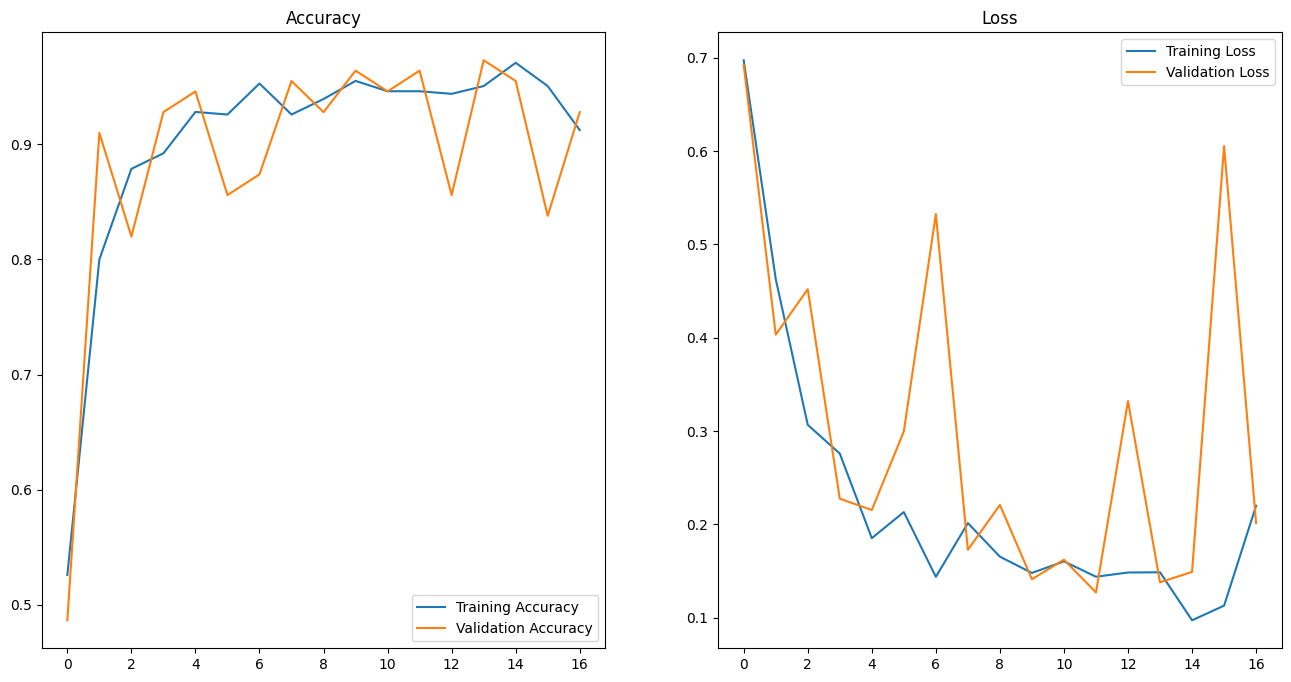

In [29]:

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, activation='relu'),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7321 - loss: 1.1204 - val_accuracy: 0.5135 - val_loss: 6.6664
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8529 - loss: 0.7860 - val_accuracy: 0.5225 - val_loss: 21.4814
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8259 - loss: 1.1898 - val_accuracy: 0.3604 - val_loss: 2.2814
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8453 - loss: 0.4999 - val_accuracy: 0.9189 - val_loss: 0.3431
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9444 - loss: 0.2824 - val_accuracy: 0.9099 - val_loss: 0.2193
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9207 - loss: 0.1612 - val_accuracy: 0.9459 - val_loss: 0.1109
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9556 - loss: 0.1079 - val_accuracy: 0.9730 - val_loss: 0.0655
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9648 - loss: 0.0833 - val_acc

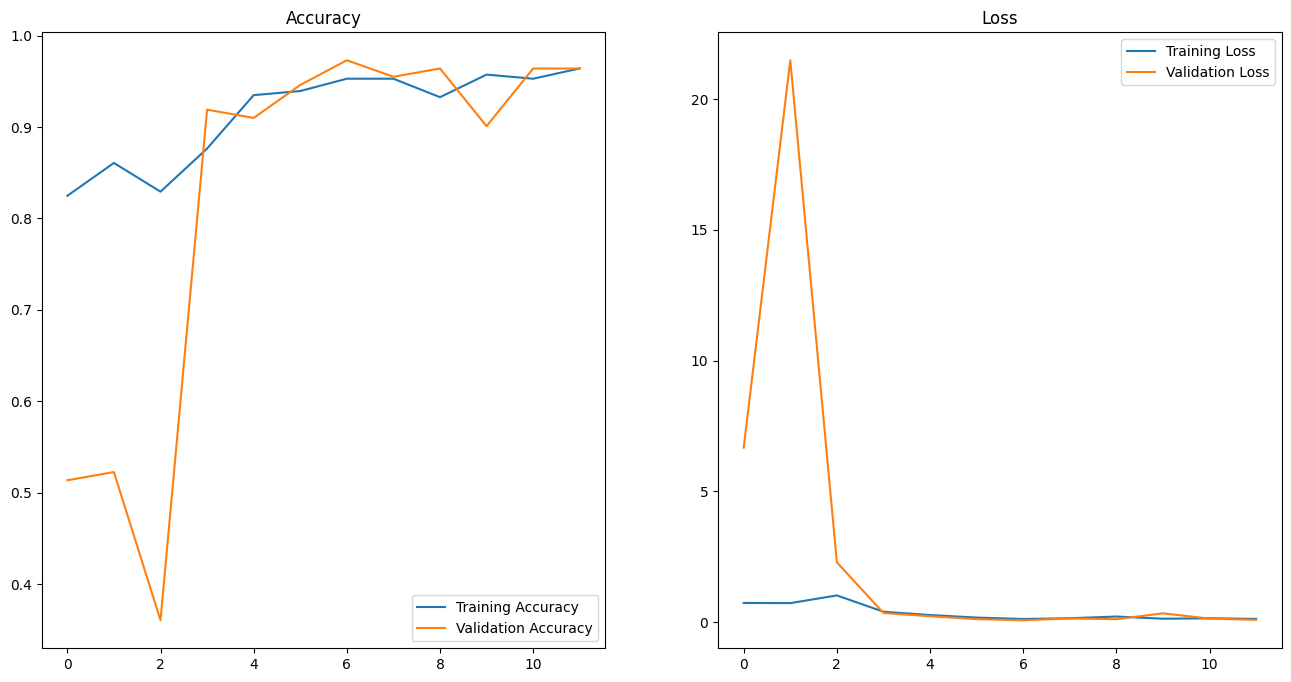

In [30]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop]
)

show_results(history)

# Predicting o new data

In [31]:
# model.predict